## IMPORTS

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib as ml
import matplotlib.pyplot as plt

In [146]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, RandomTreesEmbedding
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [147]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict

## GET DATA

In [148]:
def load_train():
    return pd.read_csv('datasets/train.csv')

In [149]:
def load_test():
    return pd.read_csv('datasets/test.csv')

In [150]:
train = load_train()
test = load_test()

## INICIAL DATA ANALYSIS

In [151]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [152]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [153]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [154]:
train.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

In [155]:
train['Sex'].value_counts() / len(train)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

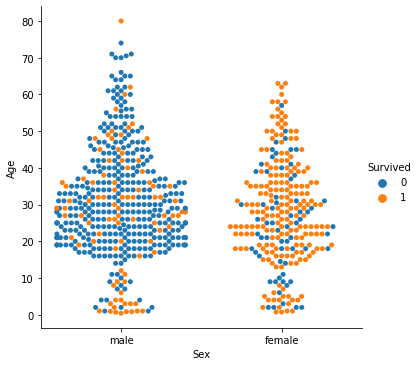

In [156]:
sns.catplot(data=train, kind='swarm', x="Sex", y='Age', hue='Survived')

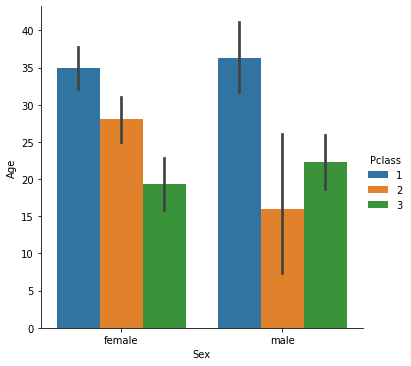

In [157]:
sns.catplot(data=train[train['Survived']==1], kind='bar', x="Sex", y='Age', hue='Pclass')

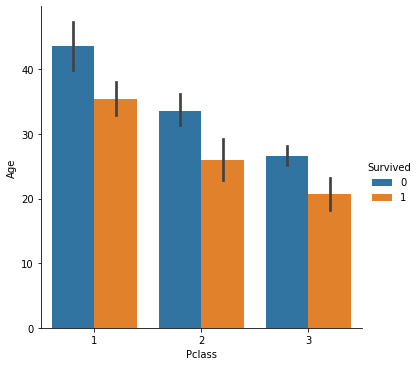

In [158]:
sns.catplot(data=train, kind='bar', x="Pclass", y='Age', hue='Survived')

In [159]:
train['Pclass'].value_counts() / len(train)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

## SETS

In [160]:
from sklearn.model_selection import train_test_split

treino, validacao = train_test_split(train, test_size=0.3, random_state=42)

X_treino = treino.drop("Survived", axis=1)
y_treino = treino['Survived']

X_valid = validacao.drop("Survived", axis=1)
y_valid = validacao['Survived']

## TRASFORMING DATA

#### Pipelines

In [161]:
pipe_fill_scaler = Pipeline([
    ('imp', SimpleImputer(strategy='median')), 
    ('scale', StandardScaler())
])

In [162]:
pipe_cat_attribs = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('num', OneHotEncoder()) 
])

In [163]:
transforms = ColumnTransformer([
    ('fill_scaler', pipe_fill_scaler, ['Age', 'Fare']), 
    ('cat_attribs', pipe_cat_attribs, ['Pclass', 'Sex', 'Embarked'])
])

## UTILS

## CROSS-VAL-SCORE

In [189]:
models = [DecisionTreeClassifier(), RandomForestClassifier(), SGDClassifier(), KNeighborsClassifier(), SVC(), LogisticRegression()]
labels = ['Age', 'Fare', 'Pclass', 'Sex', 'Embarked', 'SibSp']

for model in models:
    pipe = make_pipeline(transforms, model)
    val_scores = cross_val_score(pipe, X_treino[labels], y_treino, cv=5)
    nome_modelo = type(model).__name__ # somente para exibição
    print('Modelo: {} | Média: {:.2} | Desvio: {:.2}'.format(nome_modelo, np.mean(val_scores), np.std(val_scores)))

Modelo: DecisionTreeClassifier | Média: 0.77 | Desvio: 0.023
Modelo: RandomForestClassifier | Média: 0.8 | Desvio: 0.039
Modelo: SGDClassifier | Média: 0.73 | Desvio: 0.029
Modelo: KNeighborsClassifier | Média: 0.79 | Desvio: 0.042
Modelo: SVC | Média: 0.82 | Desvio: 0.053
Modelo: LogisticRegression | Média: 0.8 | Desvio: 0.059


In [ ]:
from sklearn.tree import export_graphviz

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

In [192]:
def display_performance(valid, pred):
    
    print("accuracy_score: {}".format(accuracy_score(valid, pred)))
    print("precision_score: {}".format(precision_score(valid, pred)))
    print("recall_score: {}".format(recall_score(valid, pred)))
    print("confusion_matrix: \n{}\n".format(confusion_matrix(valid, pred)))    
    print("classification_report: \n{}".format(classification_report(valid, pred)))
    

## RANDOM FOREST CLASSIFIER

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('fill_scaler',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat_attribs',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('num',
                                                                   OneHotEncoder())]),
                                                  ['Pclass', 'Sex',
            

In [180]:
y_predict = pipe.predict(X_valid)

In [190]:
display_performance(y_valid, y_predict)

accuracy_score: 0.7835820895522388
precision_score: 0.7523809523809524
recall_score: 0.7117117117117117
confusion_matrix: 
[[131  26]
 [ 32  79]]

classification_report: 
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       157
           1       0.75      0.71      0.73       111

    accuracy                           0.78       268
   macro avg       0.78      0.77      0.78       268
weighted avg       0.78      0.78      0.78       268



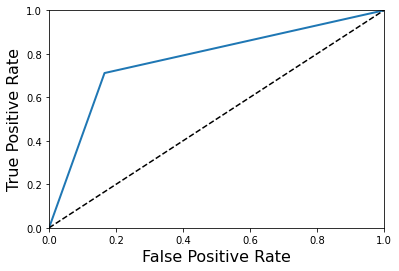

In [193]:
display_recall_curve(y_valid, y_predict)

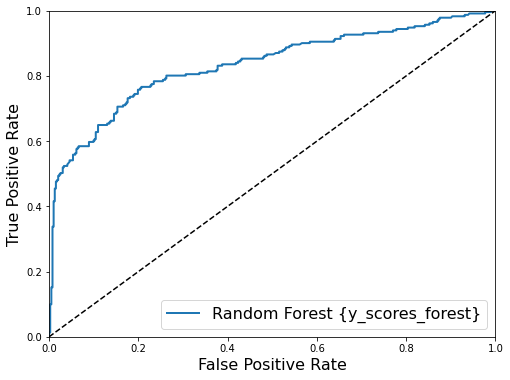

In [195]:
y_probas_forest = cross_val_predict(pipe, X_treino, y_treino, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_treino, y_scores_forest)

plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()